In [1]:
#import các thư viện
import pandas as pd
import numpy as np
%matplotlib inline 
#to plot the whatever graphic
import matplotlib.pyplot as plt #plot data
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [2]:
#import data BID
df_BID = pd.read_csv('../BID-Historical-Data.csv')
df_BID = df_BID[['Date','Price']]
df_BID

,Date,Price
0,1/2/2019,"25,639.00"
1,1/3/2019,"24,491.00"
2,1/4/2019,"24,146.60"
3,1/7/2019,"24,720.60"
4,1/8/2019,"24,491.00"
...,...,...
1107,6/12/2023,"43,650.00"
1108,6/13/2023,"44,350.00"
1109,6/14/2023,"44,000.00"
1110,6/15/2023,"43,850.00"


In [3]:
#import data VNI
df_VNI=pd.read_csv('../VN-Index-Historical-Data.csv')
df_VNI= df_VNI[['Date','Price']]
df_VNI

,Date,Price
0,1/2/2019,891.75
1,1/3/2019,878.22
2,1/4/2019,880.9
3,1/7/2019,889.64
4,1/8/2019,887.44
...,...,...
1107,6/12/2023,"1,116.02"
1108,6/13/2023,"1,122.46"
1109,6/14/2023,"1,117.42"
1110,6/15/2023,"1,116.97"


In [4]:
#Chuyển dữ liệu lần cuối, % thay đổi về dạng int
df_BID['Price']=df_BID['Price'].replace(',','',regex=True).astype(float)
df_VNI['Price']=df_VNI['Price'].replace(',','',regex=True).astype(float)

In [5]:
df = pd.merge(df_BID, df_VNI, on='Date')
df.head()

,Date,Price_x,Price_y
0,1/2/2019,25639.0,891.75
1,1/3/2019,24491.0,878.22
2,1/4/2019,24146.6,880.90
3,1/7/2019,24720.6,889.64
4,1/8/2019,24491.0,887.44


In [6]:
name_mapping = {'Price_x':'Price_BID','Price_y':'Price_VNI'}

In [7]:
df = df.rename(columns=name_mapping)
df

,Date,Price_BID,Price_VNI
0,1/2/2019,25639.0,891.75
1,1/3/2019,24491.0,878.22
2,1/4/2019,24146.6,880.90
3,1/7/2019,24720.6,889.64
4,1/8/2019,24491.0,887.44
...,...,...,...
1107,6/12/2023,43650.0,1116.02
1108,6/13/2023,44350.0,1122.46
1109,6/14/2023,44000.0,1117.42
1110,6/15/2023,43850.0,1116.97


In [8]:
# data = data.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Price_BID', 'Price_VNI']]
df = df.dropna() # Drop missing values

# Split the df into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

778
222
112


In [9]:
train_exog = train_data[["Price_VNI"]]
model = auto_arima(train_data['Price_BID'], 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12398.818, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12391.205, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12392.984, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12392.986, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12390.312, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12394.969, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.858 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  778
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6194.156
Date:                Sun, 18 Jun 2023   AIC                          12390.312
Time:                        21:34:20   BIC                          12394.968
Sample:                             0   HQIC                         12392.103
                                - 778          

In [10]:
model= SARIMAX(train_data['Price_BID'], 
 exog=train_exog,
 order=(0,1,0),
 enforce_invertibility=False, enforce_stationarity=False)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price_BID'])
test_exog = test_data[['Price_VNI']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price_BID'])
val_exog = val_data[['Price_VNI']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


778    46174.803801
779    46790.753958
780    46668.649302
781    46901.229600
782    46615.543467
           ...     
995    27887.790196
996    26526.032549
997    27276.491645
998    27706.377564
999    27459.454813
Name: predicted_mean, Length: 222, dtype: float64
            Price_VNI
Date                 
2022-12-30    1007.09
2023-01-03    1043.90
2023-01-04    1046.35
2023-01-05    1055.82
2023-01-06    1051.44
...               ...
2023-06-12    1116.02
2023-06-13    1122.46
2023-06-14    1117.42
2023-06-15    1116.97
2023-06-16    1115.22

[112 rows x 1 columns]
778    27374.175370
779    28801.055502
780    28896.025790
781    29263.115028
782    29093.331410
           ...     
885    31596.670690
886    31846.306877
887    31650.939426
888    31633.495904
889    31565.659984
Name: predicted_mean, Length: 112, dtype: float64


In [12]:
# Tính độ đo MDA trên tập test
y_test_actual = np.array(test_data['Price_BID'])
y_test_predicted = y_pred
test_correct = np.where(np.sign(np.diff(y_test_actual)) == np.sign(np.diff(y_test_predicted)), 1, 0)
test_mda = np.mean(test_correct)
# Tính độ đo MDA trên tập validation
y_val_actual = np.array(val_data['Price_BID'])
y_val_predicted = y_pred_val
val_correct = np.where(np.sign(np.diff(y_val_actual)) == np.sign(np.diff(y_val_predicted)), 1, 0)
val_mda = np.mean(val_correct)


Validation RMSE: 15059.03
Testing RMSE: 5300.10
Validation MAPE: 33.52%
Testing MAPE: 10.83%
Testing MDA: 73.76%
Validation MDA: 62.16%


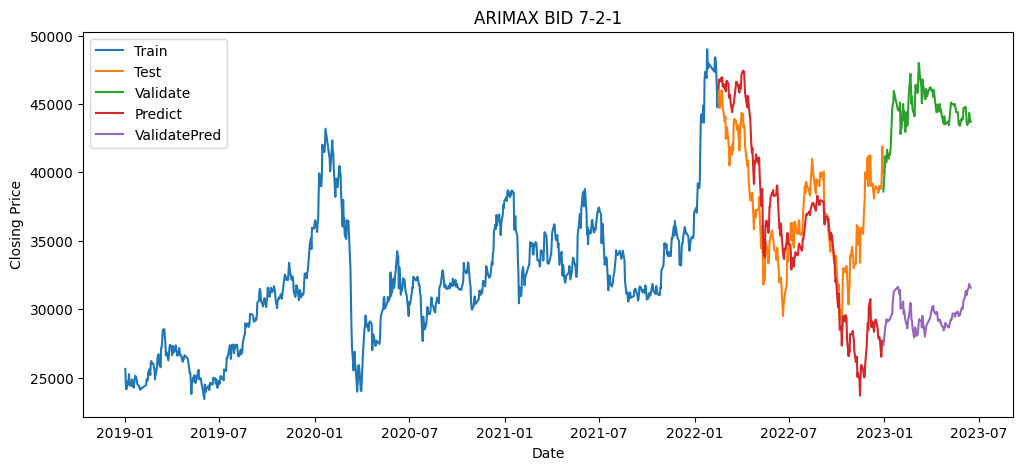

In [13]:
# 8. Tính các độ đo
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
valid_mae = mean_absolute_error(y_pred_val,y_val) # MAE
test_mae = mean_absolute_error(y_pred,y_test)
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")
print(f"Testing MDA: {test_mda*100:.2f}%")
print(f"Validation MDA: {val_mda*100:.2f}%")
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('ARIMAX BID 7-2-1')
plt.plot(train_data.index, train_data['Price_BID'])
plt.plot(test_data.index, test_data['Price_BID'])
plt.plot(val_data.index, val_data['Price_BID'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
#plt.plot(next_30_days_index,y_next_30_days)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.legend(['Train', 'Test', 'Validate','Predict','ValidatePred'])
plt.show()